In [1]:
"""nbconvert header

We are just configuring to hide some unnecessary warnings.
"""

import arpes.config
arpes.config.DOCS_BUILD = True

Activating auto-logging. Current session state plus future input saved.
Filename       : logs\unnamed_2021-07-21_18-02-49.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


# Curve Fitting in PyARPES

## Why curve fit

Curve fitting is an extremely important technique in angle resolved-photoemission because it provides a coherent way of dealing with noisy data, it allows for simple treatment of backgrounds, it avoids painful questions of interpretation inherent with some techniques, and it grants access to the rich information ARPES provides of the single particle spectral function.

## Simple curve fitting

PyARPES uses `lmfit` in order to provide a user friendly, compositional API for curve fitting. This allows users to define more complicated models using operators like `+` and `*`, but also makes the process of curve fitting transparent and simple.

Here we will prepare an EDC with a step edge, and fit it with a linear density of states multipled by the Fermi distribution and convolved with Gaussian instrumental broadening (`AffineBroadenedFD`). In general in PyARPES, we use extensions of the models available in `lmfit`, which provides an xarray compatible and unitful fitting function `guess_fit`. This has more or less the same call signature as `fit except that we do not need to pass the X and Y data separately, the X data is provided by the dataset coordinates.

Activating auto-logging. Current session state plus future input saved.
Filename       : logs\unnamed_2021-07-15_16-00-00.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


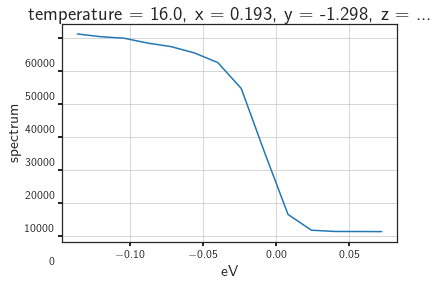

In [1]:
# first let's prepare some data to curve fit
from arpes.io import example_data

test_edc = example_data.temperature_dependence.spectrum.sel(
    eV=slice(-0.15, None)).sum("phi").isel(temperature=0)

test_edc.plot()

Now, let's fit this data with a broadened edge.

name,value,min,max,stderr,vary,expr,brute_step
const_bkg,50944.681,-inf,inf,1068.999,True,,
conv_width,0.008,0.000,inf,0.006,True,,
fd_center,-0.009,-inf,inf,0.000,True,,
fd_width,0.008,0.000,inf,0.003,True,,
lin_bkg,-77394.660,-inf,inf,9882.491,True,,
offset,1163.460,0.000,inf,321.408,True,,


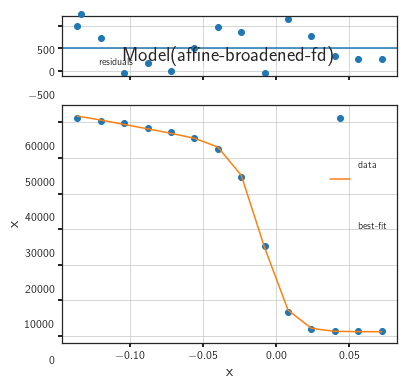

In [2]:
from arpes.fits.fit_models import AffineBroadenedFD

result = AffineBroadenedFD().guess_fit(test_edc)
result.plot()    # plot the fit, residual, etc
result           # print parameters and info

Empirically, we have a very good fit. One thing it is good to know about resolution convolved edges is that there are two width parameters: `fd_width` and `conv_width`. These are the intrinsic edge width caused by thermally excited carriers in the Fermi-Dirac distribution and a broadening which affects the entire spectrum due to instrumental effects, respectively.

Because these can have nearly degenerate effects if you have only a single edge with no peak, you may want to set one parameter or another to an appropriate value based on known experimental conditions.

From your analyzer settings and photon linewidth, you may know your resolution broadening, while from the temperature you may know the intrinsic edge width.

Before moving on, the tabular representations of parameters above was produced by letting the cell output be `result`.

## Influencing the fit by setting parametrs

Using the `params=` keyword you can provide initial guess with `value`, enforce a `max` or `min`, and request that a parameter be allowed to `vary` or not. In this case, we will force a fit with the step edge at 10 millivolts, obtaining a substantially worse result.

Let's fit again but request that the step edge must be found at positive five millivolts.

c:\users\chsta\documents\github\arpes\arpes\fits\fit_models\fermi_edge.py:57: RuntimeWarning: overflow encountered in exp
  fermi = 1 / (np.exp(dx / fd_width) + 1)
c:\users\chsta\documents\github\arpes\arpes\fits\fit_models\fermi_edge.py:57: RuntimeWarning: overflow encountered in exp
  fermi = 1 / (np.exp(dx / fd_width) + 1)
c:\users\chsta\documents\github\arpes\arpes\fits\fit_models\fermi_edge.py:57: RuntimeWarning: overflow encountered in exp
  fermi = 1 / (np.exp(dx / fd_width) + 1)


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

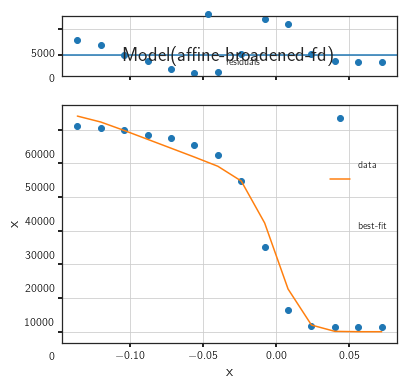

In [3]:
AffineBroadenedFD().guess_fit(
    test_edc, params={"fd_center": {
        "value": 0.005, # set the initial guess to 5meV
        "vary": False   # do not vary this parameter
    }}
).plot()

## Overview of some models

A number of models already exist including lineshapes, backgrounds, and step edges. All of these can also be easily composed to handle several lineshapes, or convolution with instrumental resolution:

* `arpes.fits.fit_models.GaussianModel`

* `arpes.fits.fit_models.VoigtModel`

* `arpes.fits.fit_models.LorentzianModel`

* `arpes.fits.fit_models.AffineBackgroundModel`

* `arpes.fits.fit_models.GStepBModel` - for a Gaussian convolved low temperature step edge

* `arpes.fits.fit_models.ExponentialDecayModel`

* `arpes.fits.fit_models.ConstantModel`

* `arpes.fits.fit_models.LinearModel`

* `arpes.fits.fit_models.FermiDiracModel`

* `arpes.analysis.gap.AffineBroadenedFD` - for a linear density of states with Gaussian convolved Fermi edge

Adding additional models is very easy, especially if they are already part of the large library of models in `lmfit`. If you are interested, have a look at the definitions in `arpes.fits.fit_models`.

Also, remember that you can combine models using standard math operators.

## Broadcasting fits

While curve fitting a single EDC or MDC is useful, often we will want to repeat an analysis across some experimental parameter or variable, such as the binding energy to track a dispersion, or across temperature to understand a phase transition.

PyARPES provides a tool, `broadcast_model` that allows for automatic and compositional curve fitting across one or more axes of a Dataset or DataArray. As before, you can use the `constraints=` keyword to enforce constraints or specify initial guesses for the fitting parameters. Broadcasts can be performed over a single dimension (`str`) or a list of dimensions (pass `[str]`). Here we demonstrate performing the fitting procedure as a function of the sample temperature, and then plot the step edge location onto the data.



Running on multiprocessing pool... this may take a while the first time.


Fitting on pool...:   0%|          | 0/34 [00:00<?, ?it/s]

Deserializing...
Finished deserializing


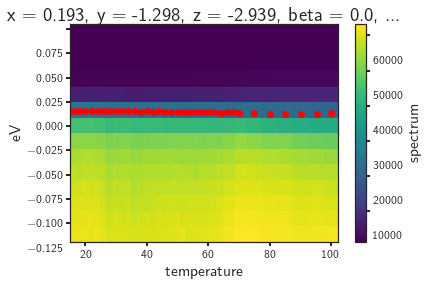

In [4]:
from arpes.fits.utilities import broadcast_model

temp_edcs = example_data.temperature_dependence.sel(
    eV=slice(-0.15, None)).sum("phi").spectrum

fit_results = broadcast_model(
    AffineBroadenedFD,  # <- fit this model class
    temp_edcs,          # <- on this dataset
    "temperature",      # <- by iterating across slices of this variable
                        #    or variables
    params={"conv_width": {"value": 0, "vary": False}}
)

temp_edcs.T.plot()
plt.scatter(*fit_results.F.p("fd_center").G.to_arrays(), color="red")

In the above, we also used the `.F` extension to `xarray` in order to get the concrete values of the `fd_center` fit parameter as an array. This is necessary because the result of a broadcast fit is a `Dataset` containing the full data, the residual, and the results. The results attribute is itself a DataArray whose values are the full results of the fit, rather than any single of the values.

Because of the rich information provided by a broadcast, PyARPES also has facilities for interacting with the results of an array of fit results more simply, furnished by the `.F` attribute.

### The .F attribute

You can get all the parameter names with `.parameter_names`.

#### Getting fit values

Using the `.F` attribute we can obtain the values for (`p`) as well as the fit error of (`s`) any fit parameters we like.

(16.0, 99.98)

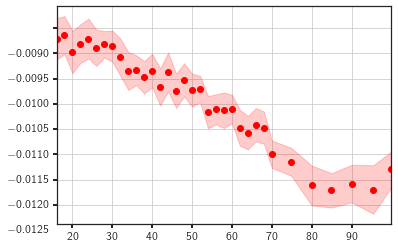

In [5]:
p, s = fit_results.F.p("fd_center"), fit_results.F.s("fd_center")

fig, ax = plt.subplots()
ax.fill_between(fit_results.temperature.values, p-s, p+s, color="red", alpha=0.2)
ax.scatter(fit_results.temperature.values, p, color="red")

ax.set_xlim(fit_results.temperature.values[[0, -1]])

## Quickly plotting a fit

We can also quickly plot a fit result with `plot_param`. This is sometimes useful for immediately plotting a fit result onto data or another plot sequence.

{}


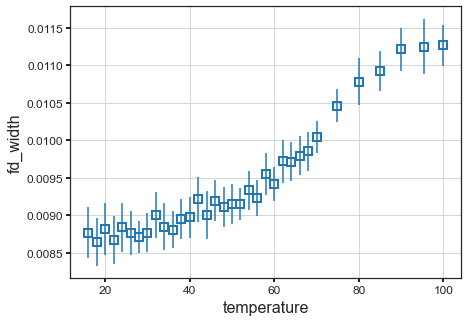

In [6]:
from arpes.config import use_tex
use_tex()
fit_results.F.plot_param("fd_width")

## Introspecting fit quality

Typically, you want to see the worst fits, so that you have some idea of how to refine them.

In [7]:
worst_fit = fit_results.F.worst_fits()[0].item()

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

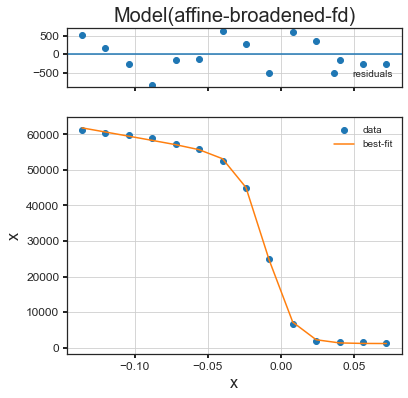

In [8]:
worst_fit.plot()

Based on this we can say that all the fits are very good. However, we may want to see how much variation there is in quality.

We can look at the `.F.mean_square_error` method for this information.

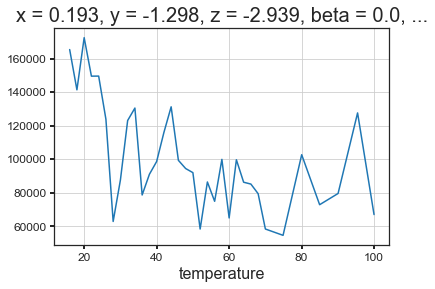

In [9]:
fit_results.F.mean_square_error().plot()

## Interactively inspecting fits

There's no substitute for inspecting fits by eye. PyARPES has Bokeh and Qt based interactive fit inspection tools. This is very much like `qt_tool` which we have already seen with the adddition that the marginal shows the curve fitting information for a broadcast fit. 

Additionally, you can use the tool to copy any given marginal's parameters to a hint dictionary which you can pass into the curve fit
for refinement.

In [10]:
from arpes.plotting.fit_tool import fit_tool

# note, you can also run fit_results.F.show()
fit_tool(fit_results)